In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.optim import SGD, Adam
import os
import warnings
from pathlib import Path
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print('device: ', device)

from quantnn.models.pytorch.common import QuantileLoss

from convert_np import ComputeStatsFromNumpyFiles, ConvertDatasetToNumpy
from load_data import GOESRETRIEVALSDataset, Mask, Standardize, ToTensor
from visualize.sample_plots import plotRandomSample
#from models.FirstGenericNet import Net 
#net_name = 'FirstGenericNet' 
from models.persiann_CNN_rec import Net 
net_name = 'persiann_CNN_rec' 

device:  cuda


In [2]:
# SETUP
channels = [8, 13]
fillvalue = -1

EPOCHS = 10
BATCH_SIZE = 1

quantiles = [0.01, 0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95, 0.99]

In [3]:
# PATHS TO DATA
path_to_load_data = '/home/ingrid/Dendrite/UserAreas/Ingrid/Dataset/' #'data/first_net_dataset/train/'
path_to_save_data = 'data/first_net_dataset/'
path_to_save_state_dict = 'models/saved_models/'

In [4]:
path_to_load_train_data = path_to_load_data + 'linkfile2017-12/'
path_to_save_train_data = path_to_save_data + 'train/npy_files'
path_to_stats = os.path.join(Path(path_to_save_train_data).parent, Path('stats.npy'))

path_to_load_val_data = path_to_load_data + 'linkfile2018-01/'
path_to_save_val_data = path_to_save_data + 'validation/npy_files'

path_to_load_test_data = path_to_load_data + 'linkfile2018-02/'
path_to_save_test_data = path_to_save_data + 'test/npy_files'

In [5]:
def importData(channels, BATCH_SIZE, path_to_load_data, path_to_save_data, path_to_stats):
    ConvertDatasetToNumpy(path_to_load_data = path_to_load_data,
                      path_to_save_data = path_to_save_data)

    dataset = GOESRETRIEVALSDataset(
        path_to_data = path_to_save_data,
        channels = channels, 
        transform = transforms.Compose([Mask(),
                                        Standardize(path_to_save_data, path_to_stats, channels),
                                        ToTensor()])
    )

    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    return(dataset, dataloader)

In [6]:
train_dataset, train_dataloader = importData(channels, BATCH_SIZE, path_to_load_train_data, 
                                              path_to_save_train_data, path_to_stats)

val_dataset, val_dataloader = importData(channels, BATCH_SIZE, path_to_load_val_data, 
                                              path_to_save_val_data, path_to_stats)

206

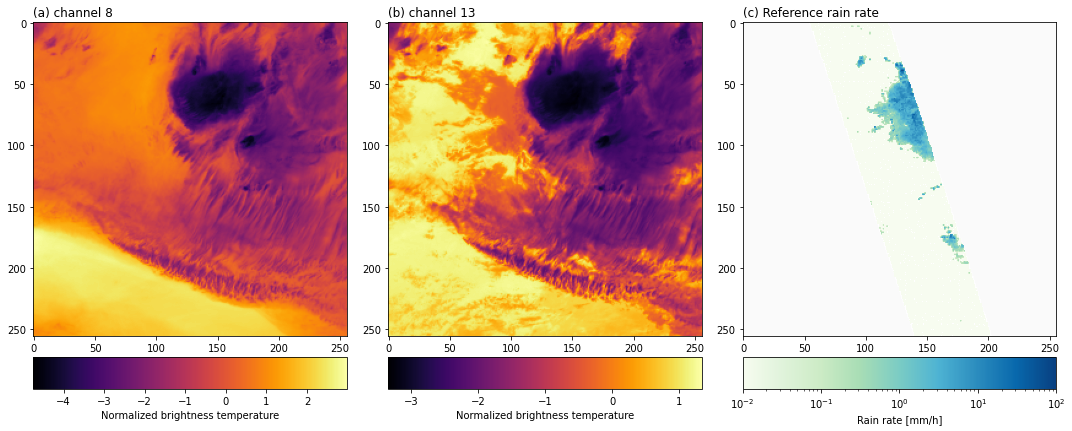

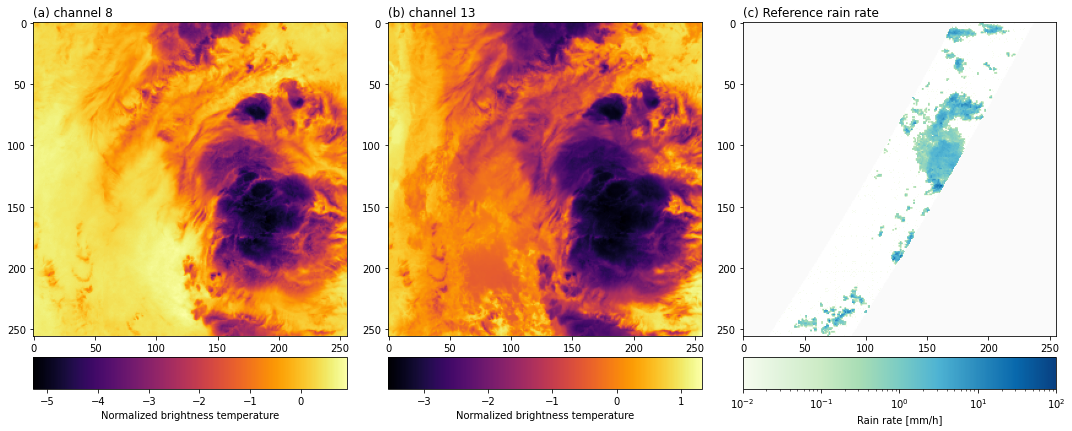

In [7]:
# PLOT RANDOM SAMPLE
plotRandomSample(train_dataset)
plotRandomSample(val_dataset)

In [8]:
# TRAINING
def train(model, X, y, optimizer, criterion):
    optimizer.zero_grad()
    
    output = model(X)
    
    loss = criterion(output, y.unsqueeze(1))
    loss.backward()
    
    optimizer.step()

    return loss

In [9]:
net = Net(len(quantiles), len(channels))
net.to(device)

criterion = QuantileLoss(quantiles=quantiles, mask=fillvalue)
criterion.to(device=device)
optimizer = SGD(net.parameters(), lr = 0.1)

In [10]:
writer = SummaryWriter()

for epoch in range(EPOCHS):
    epoch_loss = 0
    for batch_index, batch in enumerate(train_dataloader):
        X = batch['box'].to(device)
        y = batch['label'].to(device)

        batch_loss = train(net, X, y, optimizer, criterion)
        #print('batch_loss', batch_loss.item())
        epoch_loss += batch_loss.item()
    
    writer.add_scalar('Loss/train', epoch_loss/(batch_index+1), epoch)
    print('epoch', epoch, 'average train loss: ', epoch_loss/(batch_index+1))
    
    tot_val_loss = 0
    
    with torch.no_grad():
        for batch_index, batch in enumerate(val_dataloader):

            X = batch['box'].to(device).detach()
            y = batch['label'].to(device).detach()

            output = net(X)

            batch_loss_val = criterion(output, y.unsqueeze(1))

            tot_val_loss += batch_loss_val.item()

        writer.add_scalar('Loss/val', tot_val_loss/(batch_index+1), epoch)
        print('epoch', epoch, 'average validation loss: ', tot_val_loss/(batch_index+1))

input: torch.Size([1, 2, 256, 256])
c1  torch.Size([1, 8, 256, 256])
p  torch.Size([1, 8, 128, 128])
c2  torch.Size([1, 16, 128, 128])
p  torch.Size([1, 16, 64, 64])
t1  torch.Size([1, 16, 128, 128])
t2  torch.Size([1, 32, 256, 256])
c3  torch.Size([1, 64, 256, 256])
c4/outp  torch.Size([1, 13, 256, 256])
input: torch.Size([1, 2, 256, 256])
c1  torch.Size([1, 8, 256, 256])
p  torch.Size([1, 8, 128, 128])
c2  torch.Size([1, 16, 128, 128])
p  torch.Size([1, 16, 64, 64])
t1  torch.Size([1, 16, 128, 128])
t2  torch.Size([1, 32, 256, 256])
c3  torch.Size([1, 64, 256, 256])
c4/outp  torch.Size([1, 13, 256, 256])
input: torch.Size([1, 2, 256, 256])
c1  torch.Size([1, 8, 256, 256])
p  torch.Size([1, 8, 128, 128])
c2  torch.Size([1, 16, 128, 128])
p  torch.Size([1, 16, 64, 64])
t1  torch.Size([1, 16, 128, 128])
t2  torch.Size([1, 32, 256, 256])
c3  torch.Size([1, 64, 256, 256])
c4/outp  torch.Size([1, 13, 256, 256])
input: torch.Size([1, 2, 256, 256])
c1  torch.Size([1, 8, 256, 256])
p  torch.S

input: torch.Size([1, 2, 256, 256])
c1  torch.Size([1, 8, 256, 256])
p  torch.Size([1, 8, 128, 128])
c2  torch.Size([1, 16, 128, 128])
p  torch.Size([1, 16, 64, 64])
t1  torch.Size([1, 16, 128, 128])
t2  torch.Size([1, 32, 256, 256])
c3  torch.Size([1, 64, 256, 256])
c4/outp  torch.Size([1, 13, 256, 256])
input: torch.Size([1, 2, 256, 256])
c1  torch.Size([1, 8, 256, 256])
p  torch.Size([1, 8, 128, 128])
c2  torch.Size([1, 16, 128, 128])
p  torch.Size([1, 16, 64, 64])
t1  torch.Size([1, 16, 128, 128])
t2  torch.Size([1, 32, 256, 256])
c3  torch.Size([1, 64, 256, 256])
c4/outp  torch.Size([1, 13, 256, 256])
input: torch.Size([1, 2, 256, 256])
c1  torch.Size([1, 8, 256, 256])
p  torch.Size([1, 8, 128, 128])
c2  torch.Size([1, 16, 128, 128])
p  torch.Size([1, 16, 64, 64])
t1  torch.Size([1, 16, 128, 128])
t2  torch.Size([1, 32, 256, 256])
c3  torch.Size([1, 64, 256, 256])
c4/outp  torch.Size([1, 13, 256, 256])
input: torch.Size([1, 2, 256, 256])
c1  torch.Size([1, 8, 256, 256])
p  torch.S

KeyboardInterrupt: 

In [ ]:
# SAVE MODEL
#path_to_state_dict = path_to_save_state_dict +  net_name + '_state_dict-' + datetime.now().strftime("%m-%d-%YT%H:%M:%S") + '.pt'
#print(path_to_state_dict)
#torch.save(net.state_dict(), path_to_state_dict)

In [ ]:
# LOAD MODEL
net = Net(len(quantiles), len(channels), 1)
net.load_state_dict(torch.load('models/saved_models/FirstGenericNet_state_dict-03-17-2021T14:53:00.pt'))
net.to(device)

In [ ]:
# PLOT RANDOM SAMPLE AND PREDICTION
quantile_num=int(len(quantiles)/2)
#print(quantiles[quantile_num])
ind = plotRandomSample(val_dataset, net=net, quantile_num=quantile_num, device=device)
print('index ', ind)

In [ ]:
quantile_num=int(len(quantiles)/2)
y_true = []
y_pred = []
with torch.no_grad():
    for batch_index, batch in enumerate(val_dataloader):

        y_true += [batch['label'].detach().numpy()]
        
        X = batch['box'].to(device).detach()
        y_pred += [net(X)[:,quantile_num].cpu().detach().numpy()]

y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

In [ ]:
bins = np.logspace(-2, 2, 81)
indices = y_true >= 0.0


freqs, _, _ = np.histogram2d(y_true[indices], y_pred[indices], bins=bins)

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
#norm = Normalize(0, 400)

f, axs = plt.subplots(figsize=(5, 6))

ax = axs
p = ax.pcolormesh(bins, bins, freqs.T,
                  #norm=norm,  
                  cmap=plt.get_cmap('magma'))
ax.set_xlim([1e-2, 1e2])
ax.set_ylim([1e-2, 1e2])
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Reference rain rate [mm / h]")
ax.set_ylabel("Predicted rain rate [mm / h]")
#ax.set_title("(a) Title", loc="left")
ax.plot(bins, bins, c="grey", ls="--")
f.colorbar(p, ax=ax, orientation="horizontal", label="Surface precipitation [mm / h]")
ax.set_aspect(1.0)
